In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import diags, eye, kron, csr_matrix
from scipy.sparse.linalg import spsolve


In [2]:
def calculate_eddy(width=500e3, num_depth_layers=21, eta0=1, L=1e5, H=1000,
                   a=1, b=1, rho0=1025, f0=None,
                   alpha_1=0.01, alpha_2=0.01,
                   T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None,
                   q11=1.0, q12=0.0, q22=1.0):
    """
    Compute 3D geostrophic U,V and fields for an eddy with prescribed
    quadratic-form shape coefficients q11,q12,q22 (constant in z).
    """
    if f0 is None:
        f0 = 2 * 7.29e-5 * np.sin(np.radians(-34))
    g = 9.81

    x = np.linspace(-width/2, width/2, 21)
    y = np.linspace(-width/2, width/2, 21)
    z = np.linspace(-H, 0, num_depth_layers)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    taper = np.exp(Z / taper_depth) if taper_depth is not None else 1.0

    # center shift with depth
    Xc = alpha_1 * Z
    Yc = alpha_2 * Z

    # elliptical radius-squared
    dX = X - Xc
    dY = Y - Yc
    r2Q = q11 * dX**2 + 2*q12 * dX * dY + q22 * dY**2

    phi = np.exp(-r2Q / L**2) * taper

    T = -2 * phi
    S = 1.5 * phi
    P = -rho0 * g * Z

    alpha = 2e-4
    beta  = 8e-4
    sigma = rho0 * (1 - alpha*(T - T0) + beta*(S - 35))
    sigma -= sigma.mean()

    dx, dy = x[1]-x[0], y[1]-y[0]
    dsdx = np.gradient(sigma, dx, axis=0)
    dsdy = np.gradient(sigma, dy, axis=1)

    U =  g/f0 * dsdy * taper
    V = -g/f0 * dsdx * taper

    # flip so z=0 is first index
    U, V, sigma, T, S, P = [np.flip(arr, axis=2) for arr in (U,V,sigma,T,S,P)]
    z = z[::-1]

    # transpose horizontal slices
    for k in range(U.shape[2]):
        U[:,:,k] = U[:,:,k].T
        V[:,:,k] = V[:,:,k].T

    return U, V, sigma, T, S, P, x/1000, y/1000, z/1000

def plot_ellipse(Q, center=(0, 0), scale=1):
    # def normalize_matrix(A, norm_type='fro'):
    #     norm = np.linalg.norm(A, 'fro') if norm_type == 'fro' else np.max(np.abs(A))
    #     return A / norm if norm else A
    # Q = normalize_matrix(Q)

    def swap_principal_axes(Q):
        eigvals, eigvecs = np.linalg.eigh(Q)
        return eigvecs @ np.diag(eigvals[::-1]) @ eigvecs.T

    Q = swap_principal_axes(Q)
    
    eigenvalues, eigenvectors = np.linalg.eigh(Q)
    if np.any(eigenvalues < 0):
        Q = np.array([[np.abs(Q[0,0]), Q[0,1]], [Q[1,0], np.abs(Q[1,1])]])

        def flip_Q_y(Q):
            F_y = np.diag([-1, 1])
            return F_y.T @ Q @ F_y

        Q = flip_Q_y(Q)

        eigenvalues, eigenvectors = np.linalg.eigh(Q)
        if np.any(eigenvalues < 0):
            return np.nan, np.nan
            
    a, b = np.sqrt(eigenvalues) * scale
    theta = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    t = np.linspace(0, 2 * np.pi, 100)
    x, y = a * np.cos(t), b * np.sin(t)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    x_ellipse, y_ellipse = R @ np.array([x, y]) + np.array(center).reshape(2, 1)
    return x_ellipse, y_ellipse
    

In [3]:
def solve_w(U, V, x, y, z, f=-7.7e-5, N2=5e-3):
    # tic = time.time()

    x = x * 1000
    y = y * 1000
    z = z * 1000

    dx, dy = x[1] - x[0], y[1] - y[0]
    nx, ny, nz = U.shape

    # build Q
    dudz = np.gradient(U, z, axis=2)
    dvdz = np.gradient(V, z, axis=2)
    dvdx = np.gradient(V, dx, axis=0)
    dvdy = np.gradient(V, dy, axis=1)
    dudx = np.gradient(U, dx, axis=0)
    dudy = np.gradient(U, dy, axis=1)

    Qx =  f * (dudz * dvdx + dvdz * dvdy)
    Qy = -f * (dudz * dudx + dvdz * dudy)

    S = 2 * (np.gradient(Qx, dx, axis=0) + np.gradient(Qy, dy, axis=1))
    b = S.ravel(order='F')

    # finite difference operators
    ex, ey = np.ones(nx), np.ones(ny)
    Lx = diags([ex, -2*ex, ex], [-1, 0, 1], shape=(nx, nx)) / dx**2
    Ly = diags([ey, -2*ey, ey], [-1, 0, 1], shape=(ny, ny)) / dy**2
    Ix, Iy = eye(nx), eye(ny)

    # nonuniform Lz
    Lz = np.zeros((nz, nz))
    for i in range(1, nz - 1):
        dzm = z[i] - z[i - 1]
        dzp = z[i + 1] - z[i]
        Lz[i, i - 1] =  2 / (dzm * (dzm + dzp))
        Lz[i, i]     = -2 / (dzm * dzp)
        Lz[i, i + 1] =  2 / (dzp * (dzm + dzp))
    Lz = csr_matrix(Lz)
    Iz = eye(nz)

    A = N2 * (kron(kron(Iz, Iy), Lx) + kron(kron(Iz, Ly), Ix)) \
      + f**2 * kron(kron(Lz, Iy), Ix)

    w = spsolve(A.tocsr(), b).reshape((nx, ny, nz), order='F')

    # toc = time.time()
    # print(f"Elapsed time: {toc - tic:.4f} seconds")

    return w

def plotter(U, V, w, X, Y, vabs):
    rows, cols = 2, 4
    cmap = plt.get_cmap('coolwarm')
    if vabs is None:
        vabs = np.nanmax(np.abs(w))
    norm = plt.Normalize(vmin=-vabs, vmax=vabs)
    
    fig, axs = plt.subplots(rows, cols, figsize=(3*cols + 1, 3*rows), constrained_layout=True)
    
    for k in range(8):
        ax = axs[k // cols, k % cols]
        if k == 0:
            im = ax.contourf(X, Y, w[:, :, k], cmap=cmap, norm=norm)
        else:
            ax.contourf(X, Y, w[:, :, k], cmap=cmap, norm=norm)
        spacing = 1
        ax.quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing],
                  U[::spacing, ::spacing, k], V[::spacing, ::spacing, k],
                  color='k', scale=20, alpha=0.4)
        ax.axis('equal')
        ax.set_title(f'Depth {-int(round(z[k]*1000))}m')
    
    # Add communal colorbar to the right
    cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
    cbar.set_label(r'w [m Day$^-1$]')
    
    plt.show()


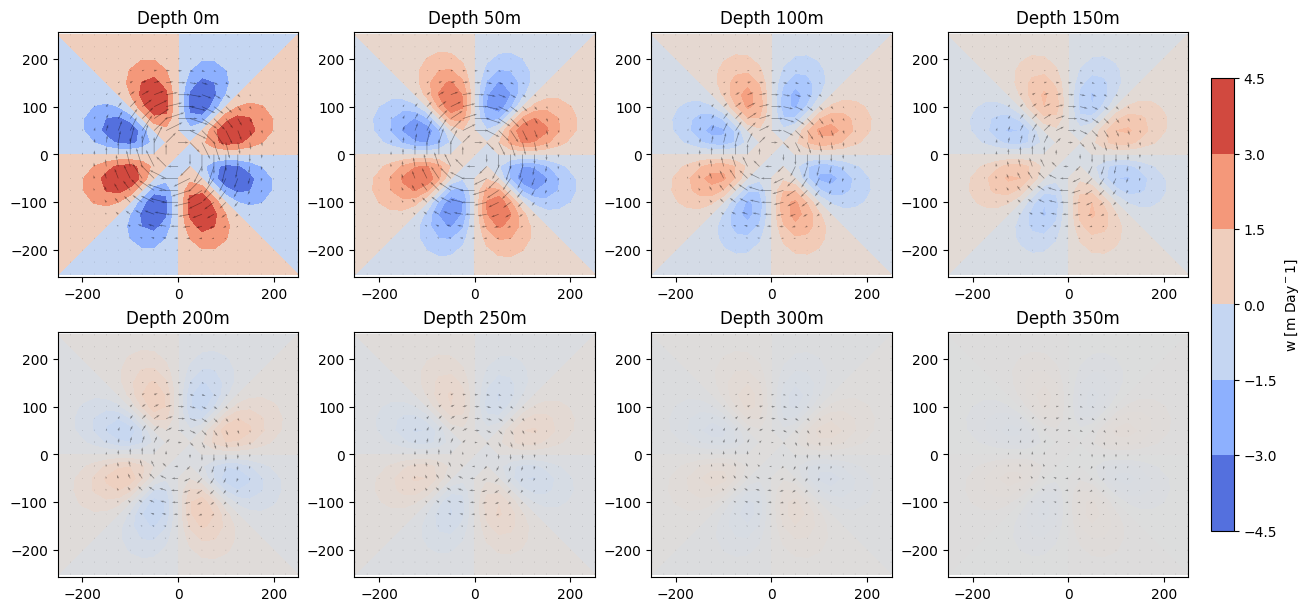

In [4]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=400)
X, Y = np.meshgrid(x, y)
w = solve_w(U, V, x, y, z)
w = w * 86400
vabs = 4.5
plotter(U, V, w, X, Y, vabs)



## Eddy Velocity Field Retrieval

We define an **elliptical Gaussian eddy** using a streamfunction

$$
\psi(x, y) = \exp\left(-\frac{1}{2} \phi(x, y)\right)
$$

where the scalar field $\phi$ is quadratic in $x$ and $y$

$$
\phi(x, y) = q_{11}(x - x_0)^2 + 2q_{12}(x - x_0)(y - y_0) + q_{22}(y - y_0)^2.
$$

This gives an elliptical shape controlled by the symmetric matrix $Q$

$$
Q = \begin{bmatrix}
q_{11} & q_{12} \\
q_{12} & q_{22}
\end{bmatrix}.
$$

The geostrophic velocity field is derived from the streamfunction via

$$
u = -\frac{\partial \psi}{\partial y}, \quad v = \frac{\partial \psi}{\partial x}.
$$

We compute the gradients using the chain rule

$$
\frac{\partial \psi}{\partial x} = -\frac{1}{2} \frac{\partial \phi}{\partial x} \exp\left(-\frac{1}{2} \phi\right), \quad
\frac{\partial \psi}{\partial y} = -\frac{1}{2} \frac{\partial \phi}{\partial y} \exp\left(-\frac{1}{2} \phi\right)
$$

with

$$
\frac{\partial \phi}{\partial x} = 2q_{11}(x - x_0) + 2q_{12}(y - y_0),
$$
$$
\frac{\partial \phi}{\partial y} = 2q_{22}(y - y_0) + 2q_{12}(x - x_0).
$$


In [5]:
def dopioe(x1, y1, u1, v1, x2, y2, u2, v2):
    def find_root(x, y, degree=3):
        """Fit a degree-3 polynomial to (x, y) and return the real root closest to x's midpoint."""
        coeffs = np.polyfit(x, y, degree)
        roots = np.roots(np.poly1d(coeffs))
        real_roots = roots[np.isreal(roots)].real
        mid_x = x[len(x) // 2]
        return real_roots[np.argmin(np.abs(real_roots - mid_x))]
    
    def tangent_at_root(x, y, root_x, degree=3):
        coeffs = np.polyfit(x, y, degree)
        slope = np.polyval(np.polyder(coeffs), root_x)
        intercept = np.polyval(coeffs, root_x) - slope * root_x
        y_fit = np.polyval(coeffs, x)
        r2 = 1 - np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2) if np.sum((y - np.mean(y))**2) != 0 else 1.0
        return slope, intercept, r2

    if np.any(np.isnan(u1)) or np.any(np.isnan(u2)):
        return np.nan, np.nan, np.nan, np.nan

    points1 = set(zip(x1, y1))
    points2 = set(zip(x2, y2))
    common_points = points1 & points2
    
    if len(common_points) != 1:
        print(f"Warning: Expected 1 common point, found {len(common_points)}.")
        return np.nan, np.nan, np.nan, np.nan
    
    center_x, center_y = next(iter(common_points))

    xx = x1 - center_x
    yy = y2 - center_y

    # Compute roots and tangents
    root_x = find_root(xx, v1)
    A1, A0, r2A = tangent_at_root(xx, u1, root_x)
    B1, B0, r2B = tangent_at_root(xx, v1, root_x)
    root_y = find_root(yy, u2)
    C1, C0, r2C = tangent_at_root(yy, u2, root_y)
    D1, D0, r2D = tangent_at_root(yy, v2, root_y)
    
    alpha = A0 if r2A > r2C else C0
    beta  = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    
    q11 = B1 / 2
    q22 = -C1 / 2
    q12 = -gamma / 2
    denom = C1 * B1 + gamma**2
    if denom == 0:
        raise ZeroDivisionError("Denominator is zero.")
        
    x0 = - (alpha * gamma + beta * C1) / denom
    y0 = (beta * gamma - alpha * B1) / denom
    w = 2 * (q11 + q22)

    Q = np.array([[q11, q12], [q12, q22]])

    return x0 + center_x, y0 + center_y, w, Q
    

Im trying to retrieve the velocity field of the eddy throguh my ESM results.\
For that to happen I need to scale the velcoity field and decide a radius of the eddy \
I intend on getting both these things by using the core vorticity calulated by DOPIOE \
I will scale such that the core vorticities match\
I define R as beign where the voriticyt drops to 1/2 the core vorticity

In [140]:
def vel_field_retrieval(x0, y0, Q, R, core_frac=0.5):
    """
    Returns:
      X, Y       : grid around (x0,y0)
      u, v       : velocity field (same scaling as dopioe core vorticity)
      R_eff      : effective eddy radius at which core vorticity drops to `core_frac`
    """
    # 1) build grid
    # x = np.linspace(x0 - plot_rad, x0 + plot_rad, 101)
    # y = np.linspace(y0 - plot_rad, y0 + plot_rad, 101)
    x = np.linspace(-150, 150, 101)
    y = np.linspace(-150, 150, 101)
    X, Y = np.meshgrid(x, y)
    dx, dy = X - x0, Y - y0

    # 2) core vorticity from dopioe (2·trace Q)
    Qabs = np.abs(Q)
    q11, q12, q22 = Qabs[0,0], Qabs[1,0], Qabs[1,1]
    vort_core = 2*(q11 + q22)

    # 3) quadratic form and its derivatives
    phi   = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
    phi_x = 2*q11*dx   + 2*q12*dy
    phi_y = 2*q22*dy   + 2*q12*dx

    # 4) choose R so that at phi_thresh the vorticity = core_frac·vort_core
    #    for a Gaussian streamfunction psi=exp(-phi/(2R^2)), 
    #    vorticity ~ Laplacian(psi) peaks at phi=0 => solve level-set on psi.
    phi_thresh = -2 * (1.0) * np.log(core_frac)
    # eigen-decomp of Q for anisotropy
    vals, _ = np.linalg.eigh(Qabs)
    a, b = np.sqrt(phi_thresh/vals[0]), np.sqrt(phi_thresh/vals[1])
    R_eff = np.sqrt(a*b) # geometric mean

    R_eff = R_eff if R is None else R

    # 5) build Gaussian streamfunction with that R
    exp_term = np.exp(-phi / (2*R_eff**2))
    psi_x = -phi_x / (2*R_eff**2) * exp_term
    psi_y = -phi_y / (2*R_eff**2) * exp_term

    # 6) velocity and rescale so max vorticity matches dopioe core
    u = -psi_y
    v =  psi_x

    # compute gaussian vorticity
    dv_dx = np.gradient(v, axis=1) / np.gradient(X, axis=1)
    du_dy = np.gradient(u, axis=0) / np.gradient(Y, axis=0)
    vort_gauss = np.abs(dv_dx - du_dy)

    # scale factor
    scale = vort_core / np.nanmax(vort_gauss)
    # scale *= 1.3
    u *= scale
    v *= scale

    return X, Y, u, v, R_eff


In [215]:
df_dopioe = pd.DataFrame(columns=['x', 'y', 'w', 'Q'])
ic, jc, r_dx = 9, 9, 2
for k in range(U.shape[-1]):
    u, v = U[:,:,k], V[:,:,k]
    u1 = u.T[ic - r_dx: ic + r_dx + 1, jc]
    v1 = v.T[ic - r_dx: ic + r_dx + 1, jc]
    x1 = X.T[ic - r_dx: ic + r_dx + 1, jc]
    y1 = Y.T[ic - r_dx: ic + r_dx + 1, jc]
    u2 = u.T[ic, jc - r_dx: jc + r_dx + 1]
    v2 = v.T[ic, jc - r_dx: jc + r_dx + 1]
    x2 = X.T[ic, jc - r_dx: jc + r_dx + 1]
    y2 = Y.T[ic, jc - r_dx: jc + r_dx + 1]
    x0, y0, w, Q = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)
    df_dopioe.loc[len(df_dopioe)] = {'x': x0, 'y': y0, 'w': w, 'Q': Q}
    if k == 0:
        _, _, _, _, R_top = vel_field_retrieval(x0, y0, Q, R=None, core_frac=0.6)
norm_w = df_dopioe['w'].abs()
norm_w = (norm_w - norm_w.min()) / (norm_w.max() - norm_w.min())
df_dopioe['R'] = R_top * norm_w
df_dopioe

,x,y,w,Q,R
0,0.394593,0.394593,-0.067872,"[[-0.016967908499099175, 0.0001034655124083549...",7.759634
1,0.394075,0.394075,-0.052859,"[[-0.013214651349524154, 8.058054069644835e-05...",6.031579
2,0.393558,0.393558,-0.041166,"[[-0.010291604902442074, 6.275737065554845e-05...",4.685765
3,0.393041,0.393041,-0.032061,"[[-0.008015128713499036, 4.88764101256511e-05]...",3.637642
4,0.392523,0.392523,-0.024969,"[[-0.00624220312618741, 3.8065703386297336e-05...",2.821361
5,0.392006,0.392006,-0.019446,"[[-0.004861444059393749, 2.96461578253971e-05]...",2.185639
6,0.391489,0.391489,-0.015144,"[[-0.0037861053005506327, 2.3088885578497463e-...",1.690537
7,0.390971,0.390971,-0.011795,"[[-0.002948628673303605, 1.798198060838814e-05...",1.304951
8,0.390454,0.390454,-0.009186,"[[-0.0022963996938964895, 1.4004644105434431e-...",1.004655
9,0.389936,0.389936,-0.007154,"[[-0.0017884420652883165, 1.0907032984340054e-...",0.770784


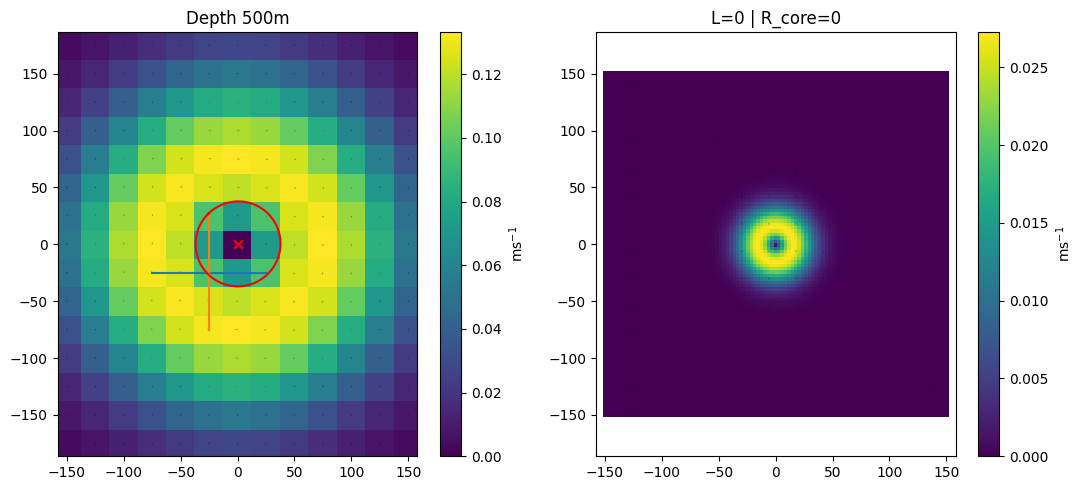

In [220]:

# z_btm = -.8
# R = R_top/np.abs(z_btm)*(z[k] - z_btm)
k = 10
data = df_dopioe.loc[k]
x0, y0, Q, R = data['x'], data['y'], data['Q'], data['R']

X_ret, Y_ret, u_ret, v_ret, R_ret = vel_field_retrieval(x0, y0, Q, R, core_frac=0.6)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(11,5))
scale = 20
width=.004
vmax = None
cs = np.hypot(U[:,:,k], V[:,:,k])
pc = axs[0].pcolor(X, Y, cs, vmin=0, vmax=vmax)
fig.colorbar(pc, ax=axs[0], label=r'ms$^{-1}$')
spacing = 1
axs[0].quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing],
          U[::spacing, ::spacing, k], V[::spacing, ::spacing, k],
          color='k', scale=scale, alpha=0.4, width=width)
axs[0].plot(x1, y1)
axs[0].plot(x2, y2)
x_ell, y_ell = plot_ellipse(Q, center=(x0, y0), scale=1000)
axs[0].plot(x_ell, y_ell, 'r')
axs[0].scatter(x0, y0, marker='x', color='r')
axs[0].axis('equal')
axs[0].set_xlim(-150, 150)
axs[0].set_ylim(-150, 150)
axs[0].set_title(f'Depth {-int(round(z[k]*1000))}m')

# Retrieved velocity field
spacing = 8
pc = axs[1].pcolor(X_ret, Y_ret, np.hypot(u_ret, v_ret), vmin=0, vmax=vmax)
fig.colorbar(pc, ax=axs[1], label=r'ms$^{-1}$')
axs[1].quiver(X_ret[::spacing, ::spacing], Y_ret[::spacing, ::spacing],
          u_ret[::spacing, ::spacing], v_ret[::spacing, ::spacing],
          color='k', scale=scale, alpha=0.4, width=width)
axs[1].axis('equal')
axs[1].set_title(f'L={int(np.sqrt(2)*R_ret)} | R_core={int(R_ret)}')
axs[1].set_xlim(-150, 150)
axs[1].set_ylim(-150, 150)

plt.tight_layout()
plt.show()


,x,y,w,q11,q12,q22,R
0,0.394593,0.394593,-0.067872,-0.016968,1.034655e-04,-0.016968,7.759634
1,0.394075,0.394075,-0.052859,-0.013215,8.058054e-05,-0.013215,6.031579
2,0.393558,0.393558,-0.041166,-0.010292,6.275737e-05,-0.010292,4.685765
3,0.393041,0.393041,-0.032061,-0.008015,4.887641e-05,-0.008015,3.637642
4,0.392523,0.392523,-0.024969,-0.006242,3.806570e-05,-0.006242,2.821361
5,0.392006,0.392006,-0.019446,-0.004861,2.964616e-05,-0.004861,2.185639
6,0.391489,0.391489,-0.015144,-0.003786,2.308889e-05,-0.003786,1.690537
7,0.390971,0.390971,-0.011795,-0.002949,1.798198e-05,-0.002949,1.304951
8,0.390454,0.390454,-0.009186,-0.002296,1.400464e-05,-0.002296,1.004655
9,0.389936,0.389936,-0.007154,-0.001788,1.090703e-05,-0.001788,0.770784


,x,y,w,q11,q12,q22,R,Depth
0,0.394593,0.394593,-0.067872,-0.016968,0.000103,-0.016968,7.759634,0.0
1,0.394075,0.394075,-0.052859,-0.013215,0.000081,-0.013215,7.274657,-50.0
2,0.393558,0.393558,-0.041166,-0.010292,0.000063,-0.010292,6.789679,-100.0
3,0.393041,0.393041,-0.032061,-0.008015,0.000049,-0.008015,6.304702,-150.0
4,0.392523,0.392523,-0.024969,-0.006242,0.000038,-0.006242,5.819725,-200.0
5,0.392006,0.392006,-0.019446,-0.004861,0.000030,-0.004861,5.334748,-250.0
6,0.391489,0.391489,-0.015144,-0.003786,0.000023,-0.003786,4.849771,-300.0
7,0.390971,0.390971,-0.011795,-0.002949,0.000018,-0.002949,4.364794,-350.0
8,0.390454,0.390454,-0.009186,-0.002296,0.000014,-0.002296,3.879817,-400.0
9,0.389936,0.389936,-0.007154,-0.001788,0.000011,-0.001788,3.394840,-450.0


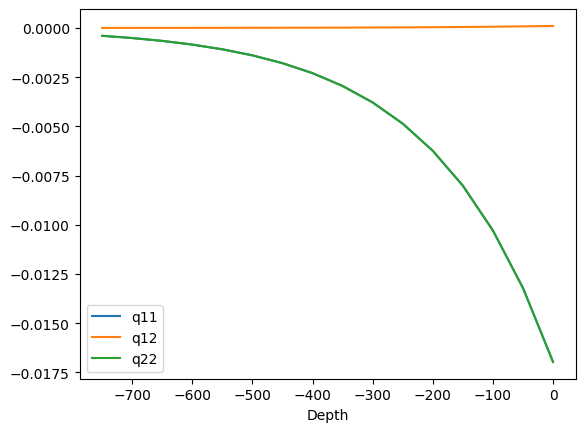

In [173]:
df_dopioe = pd.DataFrame(columns=['x', 'y', 'w', 'q11', 'q12', 'q22', 'R', 'Depth'])

ic, jc, r_dx = 9, 9, 2
u, v = U[:,:,0], V[:,:,0]
u1 = u.T[ic - r_dx: ic + r_dx + 1, jc]
v1 = v.T[ic - r_dx: ic + r_dx + 1, jc]
x1 = X.T[ic - r_dx: ic + r_dx + 1, jc]
y1 = Y.T[ic - r_dx: ic + r_dx + 1, jc]
u2 = u.T[ic, jc - r_dx: jc + r_dx + 1]
v2 = v.T[ic, jc - r_dx: jc + r_dx + 1]
x2 = X.T[ic, jc - r_dx: jc + r_dx + 1]
y2 = Y.T[ic, jc - r_dx: jc + r_dx + 1]
x0, y0, w, Q = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)
R = None
_, _, _, _, R_top = vel_field_retrieval(x0, y0, Q, R, core_frac=0.6)

for k in range(U.shape[-1]):
 
    u, v = U[:,:,k], V[:,:,k]
    u1 = u.T[ic - r_dx: ic + r_dx + 1, jc]
    v1 = v.T[ic - r_dx: ic + r_dx + 1, jc]
    x1 = X.T[ic - r_dx: ic + r_dx + 1, jc]
    y1 = Y.T[ic - r_dx: ic + r_dx + 1, jc]
    u2 = u.T[ic, jc - r_dx: jc + r_dx + 1]
    v2 = v.T[ic, jc - r_dx: jc + r_dx + 1]
    x2 = X.T[ic, jc - r_dx: jc + r_dx + 1]
    y2 = Y.T[ic, jc - r_dx: jc + r_dx + 1]
    x0, y0, w, Q = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)
    
    z_btm = -.8
    R = R_top/np.abs(z_btm)*(z[k] - z_btm)
    if R > 0:
        _, _, _, _, R_cre = vel_field_retrieval(x0, y0, Q, R, core_frac=0.6)
        df_dopioe.loc[len(df_dopioe)] = {'x': x0, 'y': y0, 'w': w, 'q11': Q[0,0], 'q12': Q[1,0], 'q22': Q[1,1], 'R': R_cre, 'Depth': z[k]*1000}
df_dopioe.plot(y=['q11', 'q12', 'q22'], x='Depth')
df_dopioe